# Introduction to Automatic Differentiation

### MAJOR ASSUMPTION

**Only supports 1st order derivative.** 
> Honestly, it's not a bad idea to only support 1st order derivatives because Reverse Mode Automatic Differentiation is horribly inefficient for higher order derivatives. This is the reason you don't see higher order derivatives used in Machine Learning!

## Topics Covered
- `Tensor` type 
- Operations on `Tensor`s
  - Matrix Multiplication
  - Matrix Vector Addition
  - Scalar Matrix Multiplication
  - Matrix Scalar Division
  - Matrix Subtraction
  - Power
  - Sum along an axis
- `brezdiff`: Automatic Differentiation Engine
- Linear Regression Example

## Custom `Tensor` type

Something to hold the computational graph!

In [1]:
mutable struct Tensor
    val::AbstractArray  # Value of the Tensor
    parents::Vector     # Who created this Tensor
    chain_rules::Vector # Chain Rule to get global gradients wrt parents

    # Constructor to initialise the Tensor (for leaf nodes)
    function Tensor(val::Union{Number, AbstractArray})
        if typeof(val) <: Number
            val = [val][:,:] # Storing Scalar as an Array
            new(val, [], [])
        else
            new(val, [], [])
        end
    end

    # Constructor to create Tensor using operations (for intermediate nodes)
    function Tensor(val::AbstractArray, parents::Vector{Tensor}, chain_rules::Vector)
        new(val, parents, chain_rules)
    end
end

`Tensor` type holds:
- `val`: Value of the node in the computational graph
- `parents`:Parents of the node in the computational graph
- `chain_rules`: How Local and Global derivatives should be multiplied (relevant when matrices are involved)

Now I can initialise `Tensors`...

In [2]:
# Initialising Scalar Value
scalar = Tensor(5)
println(scalar.val)

# Initialising Array Value
matrix = Tensor(rand(5, 3))
println(matrix.val)


[5;;]


[0.9192919896194898 0.1490267968158694 0.36522919878198734; 0.450598556194295 0.6895096137242089 0.9555891721774291; 0.7512007956553514 0.1024380013250783 0.7798491056399496; 0.6985103262902411 0.0546504364698438 0.2941554227753149; 0.741391729665269 0.8904164421460263 0.458180148567215]


## Operations on `Tensor`s

In [3]:
using Base

In [21]:
# Matrix Multiplication
function Base.:*(T1::Tensor, T2::Tensor)
    val = T1.val * T2.val
    parents = [T1, T2]

    # Chain Rule Functions defining global gradients wrt parents
    dT1 = global_grad::AbstractArray -> global_grad * transpose(T2.val)
    dT2 = global_grad::AbstractArray -> transpose(T1.val) * global_grad
    chain_rules = [dT1, dT2]

    return Tensor(val, parents, chain_rules)
end

# Scalar Matrix Multiplication
function Base.:*(T1::Number, T2::Tensor)
    val = T1 * T2.val
    parents = [T2]

    # Chain Rule Functions defining global gradients wrt parents
    dT2 = global_grad -> T1 .* global_grad
    chain_rules = [dT2]

    return Tensor(val, parents, chain_rules)
end

# Matrix Scalar Division
function Base.:/(T1::Tensor, T2::Number)
    val = T1.val / T2
    parents = [T1]

    # Chain Rule Functions defining global gradients wrt parents
    dT1 = global_grad -> global_grad .* (1/T2)
    chain_rules = [dT1]

    return Tensor(val, parents, chain_rules)
end

In [6]:
# Broadcast Addition
function Base.broadcasted(::typeof(+), T1::Tensor, T2::Tensor)
    @assert size(T2.val)[1] == 1 # Making sure that T2 is a row vector

    val = T1.val .+ T2.val
    parents = [T1, T2]

    # Chain Rule Functions defining global gradients wrt parents
    dT1 = global_grad -> global_grad .* ones(size(T1.val))
    dT2 = global_grad -> sum(global_grad, dims=1)
    chain_rules = [dT1, dT2]

    return Tensor(val, parents, chain_rules)
end

# Subtraction
function Base.:-(T1::Tensor, T2::Tensor)
    val = T1.val - T2.val
    parents = [T1, T2]

    # Chain Rule Functions defining global gradients wrt parents
    dT1 = global_grad -> global_grad .* ones(size(T1.val))
    dT2 = global_grad -> -1 .* ones(size(T2.val)) .* global_grad
    chain_rules = [dT1, dT2]

    return Tensor(val, parents, chain_rules)
end

In [7]:
# Power Operation
function Base.:^(T::Tensor, n::Number)
	val = T.val .^ n
	parents = [T]

	# Chain Rule Functions defining global gradients wrt parents
	dT = global_grad -> global_grad .* n .* T.val .^ (n-1)
	chain_rules = [dT]

	return Tensor(val, parents, chain_rules)
end

In [8]:
# Sum along an axis
function Base.sum(T::Tensor, dims::Int)
    val = sum(T.val, dims=dims)
    parents = [T]

    # Chain Rule Functions defining global gradients wrt parents
    dT = global_grad -> global_grad .* ones(size(T.val))
    chain_rules = [dT]

    return Tensor(val, parents, chain_rules)
end

In [9]:
function brezdiff(T::Tensor)
	gradients = Dict() # Dict to hold grads of T wrt all creators

	function compute(node::Tensor, global_grad)
		for (parent, chain_rule) in zip(node.parents, node.chain_rules)
			# Chain Rule
			new_global_grad = chain_rule(global_grad)

			# Checking if grad present or not
			if haskey(gradients, parent)
				gradients[parent] += new_global_grad
			else
				gradients[parent] = new_global_grad
			end

			# Recusive call
			compute(parent, new_global_grad)
		end
	end

	# Output Node
	dT_dT = 1
	compute(T, dT_dT)

	return gradients
end

brezdiff (generic function with 1 method)

# Example: Linear Regression

Ground truth W: [0.7614842422627793;;]
Ground truth b: [0.2404751148013642;;]


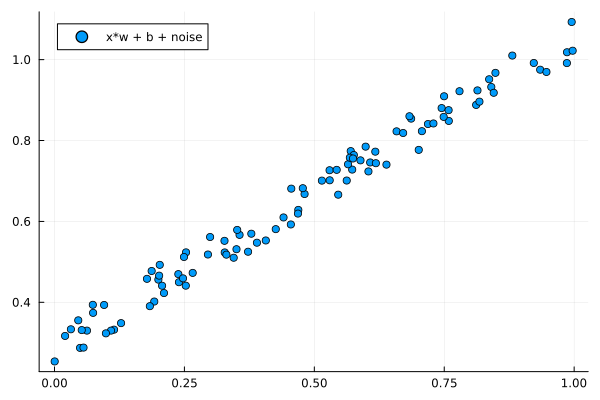

In [10]:
using Plots

# Creating Dataset
x = rand(100, 1)
w_true = rand(1, 1)
b_true = rand(1, 1)
y = x * w_true .+ b_true + rand(100, 1)*0.1

println("Ground truth W: ", w_true)
println("Ground truth b: ", b_true)

# Visualise Dataset
scatter(x, y, label="x*w + b + noise")

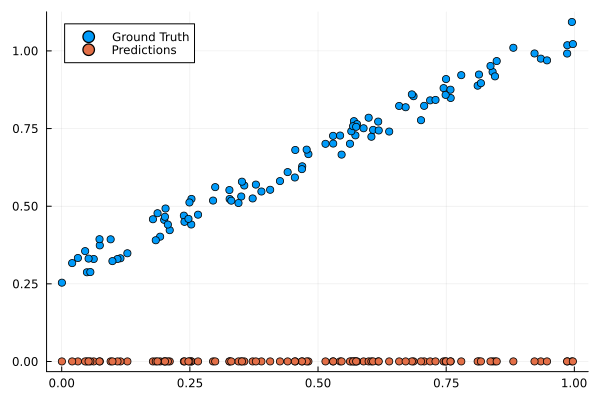

In [29]:
# Converting Data to Tensors
X = Tensor(x)
Y = Tensor(y)

# Initial Guess Model
W = Tensor(rand(1,1)*0.001)
b = Tensor(rand(1,1)*0.001)

function linear(X, W, b)
    return X * W .+ b
end


# Visualise Dataset vs Guess
scatter([x, x], [y, linear(X, W, b).val], label=["Ground Truth" "Predictions"])

In [30]:
# Loss Function
function mse(pred, Y)
    return sum((pred-Y)^2, 1)/length(Y.val)
end

mse (generic function with 1 method)

In [31]:
# 100 iterations
for i=1:1000
    # Forward Pass
    Z = linear(X, W, b)
    # Loss Calculation
    l = mse(Z, Y)
    # Gradient Calculation
    dl = brezdiff(l)

    # Updating Parameters
    W.val = W.val - 0.1 * dl[W]
    b.val = b.val - 0.1 * dl[b]

    if i % 100 == 0
        println("Iteration $(i); MSE $(mse(linear(X, W, b), Y).val)")
    end
end

Iteration 100; MSE [0.002543963267245209;;]
Iteration 200; MSE [0.0010510055070418994;;]
Iteration 300; MSE [0.0009258173439945608;;]
Iteration 400; MSE [0.000915320010054562;;]
Iteration 500; MSE [0.0009144397829055607;;]
Iteration 600; MSE [0.0009143659737042658;;]
Iteration 700; MSE [0.0009143597846220478;;]
Iteration 800; MSE [0.0009143592656523523;;]
Iteration 900; MSE [0.0009143592221354729;;]


Iteration 1000; MSE [0.0009143592184864758;;]


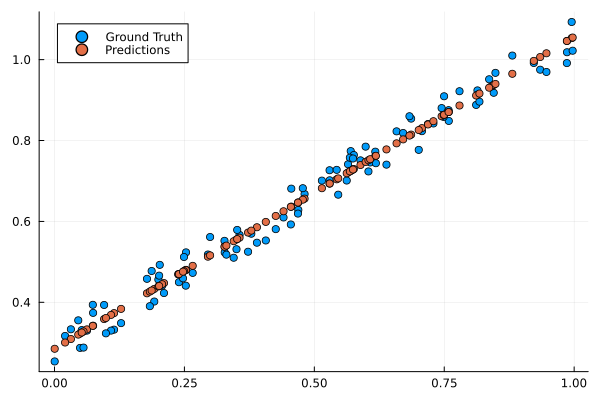

In [32]:
# Visualise Dataset vs Guess
scatter([x, x], [y, linear(X, W, b).val], label=["Ground Truth" "Predictions"])